In [49]:
import os
import sys
import re

src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)
data_dir = os.path.join(os.getcwd(), '..', 'data')

# import libraries here; add more as necessary
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt

from import_module import import_raw_data
import etl
import pipe

import joblib


# magic word for producing visualizations in notebook
%matplotlib inline

# Supervised Learning Model

Import training data

In [50]:
mailout_train = import_raw_data('Udacity_MAILOUT_052018_TRAIN.csv',data_dir)
mailout_train.head()
mailout_train = etl.clean_data(mailout_train,data_dir,True)

The data dictionary is imported.
The data dictionary is used to map the missing values.
Attribute PRAEGENDE_JUGENDJAHRE_MAINSTREAM is not available in DataFrame.
Attribute PRAEGENDE_JUGENDJAHRE_YEARS is not available in DataFrame.
Attribute CAMEO_INTL_Economic is not available in DataFrame.
Attribute CAMEO_INTL_Family is not available in DataFrame.
The functions engineer_cameo_intl and engineer_praegende_jj are used to engineer additional variables
The following attributes are dropped because they are not in the data dictionary: []
The following attributes are dropped because they have too many missings or too many levels: ['LNR' 'AGER_TYP' 'ALTER_HH' 'ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3'
 'ALTER_KIND4' 'ALTERSKATEGORIE_FEIN' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015'
 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24'
 'D19_GESAMT_DATUM' 'D19_GESAMT_OFFLINE_D

Create transformation pipeline with data dictionary 

In [51]:
data_dict_path = os.path.join(data_dir,'01_preprocessed/','data_dictionary_full.xlsx')
data_dict = pd.read_excel(data_dict_path, index_col=0)
col_trans = pipe.define_pipeline(data_dict)

In [52]:
X_train = mailout_train.drop(columns= 'RESPONSE',axis=1)
y_train = mailout_train["RESPONSE"].values

Create pipeline for model fitting and parameter grid

In [53]:
model_pipe = Pipeline([
        ('transform', col_trans),
        ('clf', GradientBoostingClassifier(random_state=42))
        ])

In [54]:
params = [{'clf__max_depth': [3],
           'clf__learning_rate': [0.05,0.1],
           'clf__min_samples_split': [2],
           'clf__n_estimators': [50,100]}]  

In [55]:
gridsearch = GridSearchCV(model_pipe,params,scoring='roc_auc',verbose=3,cv=3)
gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=50;, score=0.672 total time=  57.0s
[CV 2/3] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=50;, score=0.711 total time=  55.5s
[CV 3/3] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=50;, score=0.693 total time=  54.0s
[CV 1/3] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=100;, score=0.667 total time= 1.8min
[CV 2/3] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=100;, score=0.708 total time= 1.8min
[CV 3/3] END clf__learning_rate=0.05, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=100;, score=0.688 total time= 1.8min
[CV 1/3] END clf__learning_rate=0.1, clf__max_depth=3, clf__min_samples_split=2, clf__n_estimators=50;, score=0.666 total

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=99,
                                                                                                        strategy='constant')),
                                                                                         ('one_hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         array(['AKT_DAT_KL', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_T...
                                             

check results 

In [59]:
gridsearch.cv_results_['params']

[{'clf__learning_rate': 0.05,
  'clf__max_depth': 3,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 50},
 {'clf__learning_rate': 0.05,
  'clf__max_depth': 3,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 100},
 {'clf__learning_rate': 0.1,
  'clf__max_depth': 3,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 50},
 {'clf__learning_rate': 0.1,
  'clf__max_depth': 3,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 100}]

In [57]:
gridsearch.cv_results_['mean_test_score']

array([0.69210606, 0.68764682, 0.69087372, 0.68589449])

In [34]:
cat_vars = pipe.get_attr_by_type('categorical',data_dict)
cat_vars_ohe = gridsearch.best_estimator_.named_steps['transform'].named_transformers_['categorical']['one_hot'].get_feature_names(cat_vars)
num_vars = pipe.get_attr_by_type('numeric',data_dict)
bin_vars = pipe.get_attr_by_type('binary',data_dict)
all_vars = np.concatenate((cat_vars_ohe ,num_vars,bin_vars))

In the following feature importance you can see the most important features. Especially the Konsumtyp_max has the most important influence on the model.

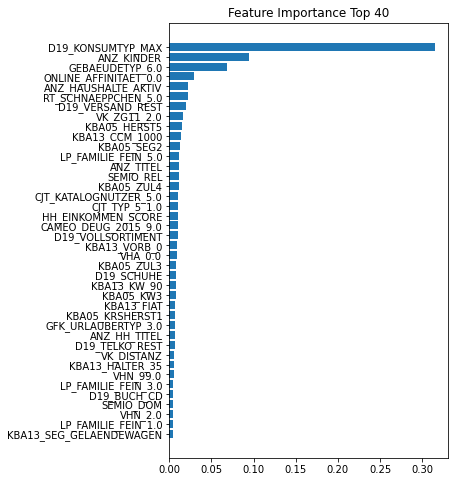

In [105]:
feature_importances= gridsearch.best_estimator_.steps[1][1].feature_importances_
feature_imp_plot_path = os.path.join(data_dir,'99_plots','feature_importance.png')

feature_importances_series = pd.Series(feature_importances, index=all_vars).sort_values()[-40:]
plt.figure(figsize=(5, 8))
plt.barh(feature_importances_series.index,feature_importances_series)

plt.title('Feature Importance Top 40')
plt.savefig(feature_imp_plot_path,bbox_inches = 'tight')

Entire pipeline is saved so it can be used for later predictions

In [106]:
gridsearch_path = os.path.join(data_dir,'02_models/','gridsearch.pkl')
joblib.dump(gridsearch, gridsearch_path) 

['/Users/matthiaslenfers/code/arvato_capstone/notebooks/../data/02_models/gridsearch.pkl']

# Kaggle Competition

Load previously done object with fitted pipeline

In [107]:
gridsearch = joblib.load(gridsearch_path) 

In [108]:
mailout_test = import_raw_data('Udacity_MAILOUT_052018_TEST.csv',data_dir)
mailout_test_cleaned = etl.clean_data(mailout_test,data_dir)
mailout_test_preds = gridsearch.predict_proba(mailout_test_cleaned)[:,1]

The data dictionary is imported.
The data dictionary is used to map the missing values.
Attribute PRAEGENDE_JUGENDJAHRE_MAINSTREAM is not available in DataFrame.
Attribute PRAEGENDE_JUGENDJAHRE_YEARS is not available in DataFrame.
Attribute CAMEO_INTL_Economic is not available in DataFrame.
Attribute CAMEO_INTL_Family is not available in DataFrame.
The functions engineer_cameo_intl and engineer_praegende_jj are used to engineer additional variables
The following attributes are dropped because they are not in the data dictionary: []
The following attributes are dropped because they have too many missings or too many levels: ['LNR' 'AGER_TYP' 'ALTER_HH' 'ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3'
 'ALTER_KIND4' 'ALTERSKATEGORIE_FEIN' 'CAMEO_DEU_2015' 'CAMEO_INTL_2015'
 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24'
 'D19_GESAMT_DATUM' 'D19_GESAMT_OFFLINE_D

Put all together in dataframe which can be saved afterwards

In [109]:
test_result_df = pd.DataFrame({
  'LNR': mailout_test['LNR'],
  'RESPONSE': mailout_test_preds
}
)

Save in folder models

In [110]:
test_result_path = os.path.join(data_dir,'02_models/','kaggle_output_test.csv')
test_result_df.to_csv(test_result_path,index=False)